# Notebook 3: Introduction to coordinate reference systems (CRS)

In this notebook we will learn the basics of working with CRSs with Python. For our land use analysis, we have datasets with different CRSs. We need to choose one CRS and make sure all of our data is projected to that CRS.

- https://pubs.usgs.gov/pp/1395/report.pdf
- https://www.usgs.gov/publications/map-projections-used-us-geological-survey

## Get the CRS for raster and vector data

In [7]:
# Load libraries
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import rioxarray
import geopandas as gpd


Use rioxarray's [open_rasterio()](https://corteva.github.io/rioxarray/html/rioxarray.html) method to read the TIFF file into an xarray `DataArray`. This function has numerous optional input arguments, but for our file we can simply pass in the path to the file and leave everything else at their default values.

In [8]:
ou_landcover_2021_da = rioxarray.open_rasterio(Path(Path.cwd(), 'data', 'ou_land_cover_2021.tif'))
ou_landcover_2021_da

<xarray.DataArray (band: 1, y: 166, x: 375)>
[62250 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 1.034e+06 1.034e+06 ... 1.045e+06 1.045e+06
  * y            (y) float64 2.258e+06 2.258e+06 ... 2.253e+06 2.253e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:        Area
    LAYER_TYPE:           thematic
    OVERVIEWS_ALGORITHM:  IMAGINE Nearest Neighbor Resampling
    scale_factor:         1.0
    add_offset:           0.0
    long_name:            Layer_1

In [9]:
mi_places_file = Path('../data', 'cb_2022_26_place_500k', 'cb_2022_26_place_500k.shp')
mi_places_gdf = gpd.read_file(mi_places_file)

ou_places_gdf = mi_places_gdf.query('NAME == "Auburn Hills" or NAME == "Rochester Hills"')
ou_places_gdf

,STATEFP,PLACEFP,PLACENS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
471,26,04105,01625860,1600000US2604105,2604105,Auburn Hills,Auburn Hills city,MI,Michigan,25,43095047,113296,"POLYGON ((-83.32895 42.70592, -83.30717 42.707..."
731,26,69035,01626990,1600000US2669035,2669035,Rochester Hills,Rochester Hills city,MI,Michigan,25,84960992,254848,"POLYGON ((-83.21403 42.70952, -83.19542 42.709..."


In [10]:
ou_boundary_file = Path('../data', 'ou_boundary.geojson')
ou_boundary_gdf = gpd.read_file(ou_boundary_file)

```
{
"type": "FeatureCollection",
"name": "ou_boundary",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "fid": 1 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ -83.220509168388844, 42.678653446491893 ], [ -83.214464053848729, 42.678723363504986 ], [ -83.210359202794379, 42.679828386721063 ], [ -83.194121952514863, 42.68031233903384 ], [ -83.193293099256138, 42.660199281509463 ], [ -83.19932851264484, 42.660173960983528 ], [ -83.219499255162631, 42.653238421627883 ], [ -83.216759168858616, 42.659141411113964 ], [ -83.217451868747403, 42.662629547726418 ], [ -83.218857978317274, 42.664900089508016 ], [ -83.21972258817641, 42.666806311613314 ], [ -83.220509168388844, 42.678653446491893 ] ] ] } }
]
}

```

<Axes: >

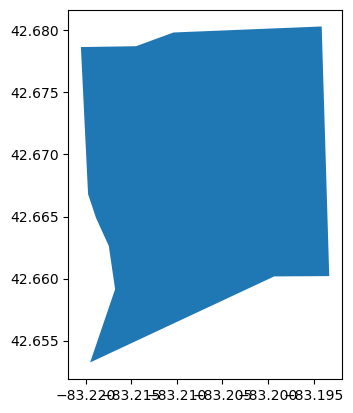

In [7]:
ou_boundary_gdf.plot()

**NOTE**

There's some trickiness with the CRS here. Note that the coordinates are in long/lat order. See

- https://github.com/CityScope/CS_choiceModels/issues/4
- https://github.com/OSGeo/gdal/issues/2035

  Once we read it into GeoPandas, the CRS gets assigned as EPSG:4326.

From https://rgdal.r-forge.r-project.org/articles/CRS_projections_transformations.html (R Bivend)

> It will be useful to know that in general "OGC:CRS84" should be used instead of "EPSG:4326", because the latter presupposes that Latitude is always ordered before Longitude. "OGC:CRS84" is the standard representation used by GeoJSON, with coordinates always ordered Longitude before Latitude. 

So, we have three different datasets:

- a raster containing land use classification values
- a vector containing the boundaries of Auburn Hills and Rochester Hills
- a vector containing the boundaries of Oakland University (manually created in QGIS).

In order to plot all three on the same map, we need to make sure we use a common CRS. First, let's confirm which CRS is being used for each.

For raster data stored in an xarray `DataArray`, we use the rioxarray `rio` accessor to get the `crs` property. The `rio` accessor is how you use the geospatial functionality that rioxarray adds to xarray.

In [5]:
print(ou_landcover_2021_da.rio.crs)

PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


The representation above is known as WKT, or [Well Known Text](https://en.wikipedia.org/wiki/Well-known_text_representation_of_coordinate_reference_systems). It is meant to be human readable as well as machine readable.

From the above, we can determine that the [Albers Conical Equal Area](https://en.wikipedia.org/wiki/Albers_projection) projected CRS is being used for this raster data. This CRS is commonly used for North America and is one of the [projections used by the USGS](https://www.usgs.gov/publications/map-projections-used-us-geological-survey).

For the `GeoDataFrame` objects containing vector data, we can just use the `crs` property directly.

In [11]:
print(f'ou_places_gdf CRS: {ou_places_gdf.crs}')

ou_places_gdf CRS: EPSG:4269


In [12]:
print(f'ou_boundary_gdf CRS: {ou_boundary_gdf.crs}')

ou_boundary_gdf CRS: EPSG:4326


Both of these CRSs seem to use longitude and latitude for their X and Y coordinate values. We know this is the case for EPSG:4326. What exactly is EPSG:4269? Googling "EPSG:4326 vs EPSG:4269" leads to this informative post on GIS StackExchange:

- [https://gis.stackexchange.com/questions/170839/is-re-projection-needed-from-srid-4326-wgs-84-to-srid-4269-nad-83](EPSG:4269)

While both projections use long/lat, they use different underlying datums (ellipsoid models of the earth). Regardless, we want to use the Albers Conical Equal Area projection for our plot as it is a projected CRS, whereas EPSG:4326 is not.

How do we do this? Many geospatial analysis packages have reprojection capabilities - usually they are leveraging GDAL and PROJ. However, a few things to keep in mind:

- reprojecting large raster files is computationally demanding. I've had problems doing such reprojections with Python packages and have had to resort to the GDAL command line utilities (which are awesome).
- it can be tricky to correctly specify the textual code for a given CRS (more on this below).

### Using GeoPandas to reproject vector data

GeoPandas has a `to_crs` method that can reproject the `GeoDataFrame` to any projection we wish. 

In [14]:
help(ou_places_gdf.to_crs)

Help on method to_crs in module geopandas.geodataframe:

to_crs(crs=None, epsg=None, inplace=False) method of geopandas.geodataframe.GeoDataFrame instance
    Transform geometries to a new coordinate reference system.
    
    Transform all geometries in an active geometry column to a different coordinate
    reference system.  The ``crs`` attribute on the current GeoSeries must
    be set.  Either ``crs`` or ``epsg`` may be specified for output.
    
    This method will transform all points in all objects. It has no notion
    of projecting entire geometries.  All segments joining points are
    assumed to be lines in the current projection, not geodesics. Objects
    crossing the dateline (or other projection boundary) will have
    undesirable behavior.
    
    Parameters
    ----------
    crs : pyproj.CRS, optional if `epsg` is specified
        The value can be anything accepted by
        :meth:`pyproj.CRS.from_user_input() <pyproj.crs.CRS.from_user_input>`,
        such as an

The first two arguments, `crs` and `epsg`, give us a few ways to specify the destination CRS. If you look closely at the `crs` argument, it expects a `pyproj.CRS` object or a valid text representation of the CRS such as "EPSG:4326" or a WKT string. What is `pyproj`?

The [pyproj library](https://pyproj4.github.io/pyproj/stable/) is a:

> Python interface to PROJ (cartographic projections and coordinate transformations library).

According to the docus, `pyproj.crs.CRS` provides a "Pythonic Coordinate Reference System manager".

In [15]:
crs_land_use_raster = ou_landcover_2021_da.rio.crs
crs_land_use_raster

CRS.from_wkt('PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

Now we can use this existing `CRS` object to specify the destination CRS for our vector data.

In [16]:
ou_places_aea_gdf = ou_places_gdf.to_crs(crs_land_use_raster)
ou_boundary_aea_gdf = ou_boundary_gdf.to_crs(crs_land_use_raster)

In [17]:
ou_places_aea_gdf.crs

<Projected CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84" ...>
Name: Albers_Conical_Equal_Area
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
ou_boundary_aea_gdf.crs

<Projected CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84" ...>
Name: Albers_Conical_Equal_Area
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

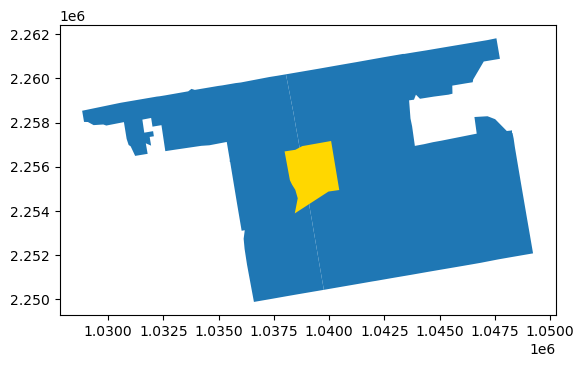

In [22]:
fig, ax = plt.subplots()
ou_places_aea_gdf.plot(ax=ax)
ou_boundary_aea_gdf.plot(ax=ax, color='gold')

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

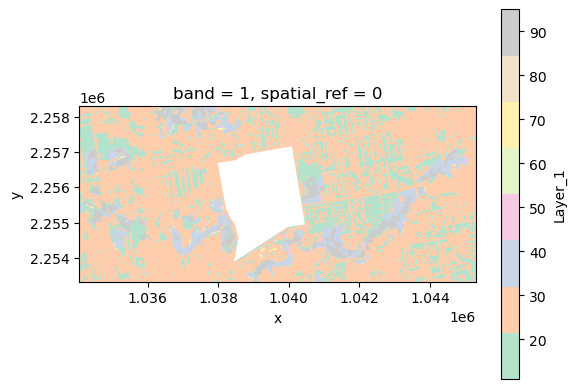

In [33]:
fig, ax = plt.subplots()
ou_places_aea_gdf.plot(ax=ax)
ou_landcover_2021_da.plot(ax=ax, cmap='Pastel2')
ou_boundary_aea_gdf.plot(ax=ax, color='white')


In [25]:
import cartopy.crs as ccrs                   # import projections

In [26]:
crs_aea = ccrs.AlbersEqualArea(central_longitude=-96,
                               central_latitude=40,
                               standard_parallels=(20.0, 60.0))

In [28]:
ou_places_aea_gdf.total_bounds

array([1028821.72370821, 2249882.28354187, 1049224.58562468,
       2261812.53566168])

In [29]:
ou_places_extent = (ou_places_aea_gdf.total_bounds[0], 
                    ou_places_aea_gdf.total_bounds[2], 
                    ou_places_aea_gdf.total_bounds[1], 
                    ou_places_aea_gdf.total_bounds[3])

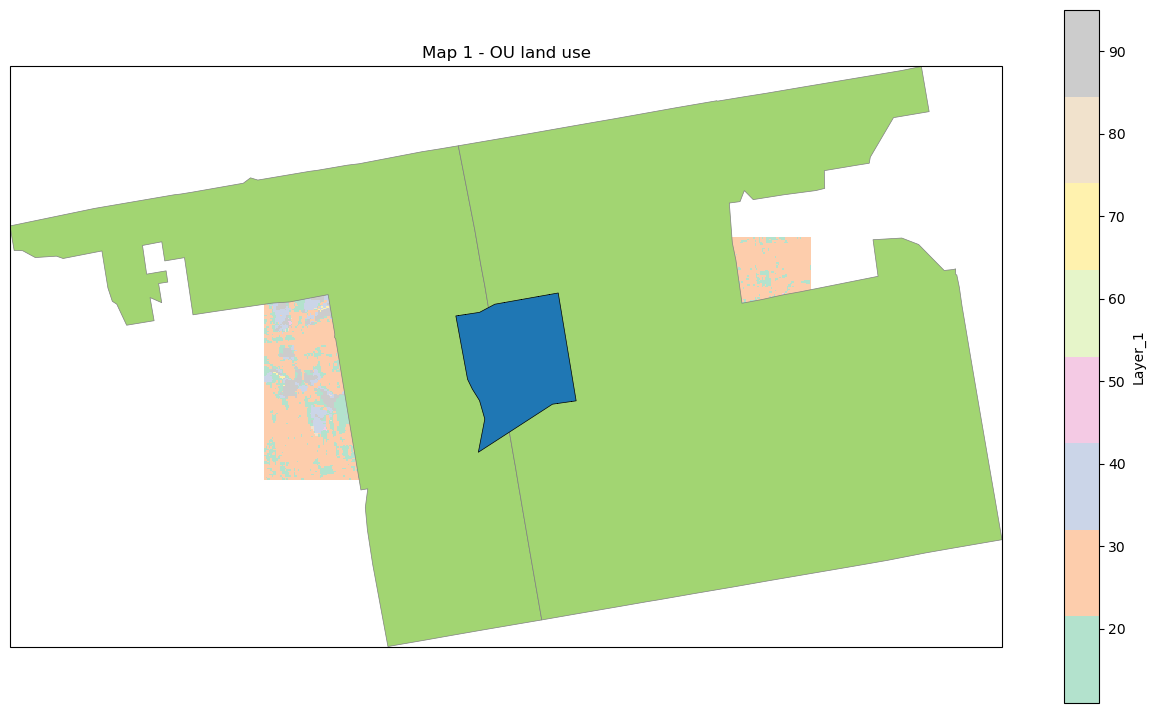

In [32]:
# Create figure and set size
fig1 = plt.figure()
fig1.set_figheight(9)
fig1.set_figwidth(16)

# create a set of axes with desired projection  
ax1 = plt.axes(projection = crs_aea)

# Set map extent
ax1.set_extent(ou_places_extent, crs = crs_aea)

# Add vectors
ax1.add_geometries(ou_places_aea_gdf.geometry, crs=crs_aea, facecolor="#a2d572", edgecolor="grey", linewidth=0.5) # for Lat/Lon data.
ax1.add_geometries(ou_boundary_aea_gdf.geometry, crs=crs_aea, edgecolor="black", linewidth=0.5) # for Lat/Lon data.


# Add land use raster
ou_landcover_2021_da.plot(ax=ax1, cmap='Pastel2')

ax1.set_title("Map 1 - OU land use")                    
plt.show()

In [5]:
ou_boundary_gdf

,fid,geometry
0,1,"POLYGON ((-83.22051 42.67865, -83.21446 42.678..."


In [8]:
ou_boundary_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Working with `DataArray` objects

From the output above we can see that `ou_landcover_2021_da` consists of a single band with an associated data matrix for that band. Use the `shape` property to see the matrix dimensions.

In [4]:
ou_landcover_2021_da.shape

(1, 166, 375)

The first dimension is the band, the second is associated with latitude (`y`) and the third is associated with longitude (`x`). So, our matrix has 166 rows and 375 columns.

To get at the actual values we use the `values` property of the `DataArray`. For assets with multiple bands (such as visual), each band has an associated (y, x) matrix.

In [5]:
ou_landcover_2021_da.values

array([[[23, 23, 23, ..., 22, 22, 23],
        [24, 23, 23, ..., 24, 23, 23],
        [24, 24, 23, ..., 24, 22, 23],
        ...,
        [22, 22, 23, ..., 22, 21, 21],
        [22, 21, 22, ..., 22, 21, 21],
        [23, 22, 21, ..., 22, 21, 21]]], dtype=uint8)

What is the data type of this matrix?

In [6]:
type(ou_landcover_2021_da.values)

numpy.ndarray

Ah, so xarray is using numpy under the hood. That means we can use standard numpy methods to explore and modify the array. By now, you've probably realized that this array is the raster data. That's it. Raster data is just an array of values. Well, there's a little more to it. In a bit we'll look at the actual `x` and `y` coordinate values.

In this case, the array values are discrete classification levels describing land use in the NLCD. From their website, I found the legend defining the values. Notice that there are groupings of values. For example, all values whose leading digit is a `2` (i.e in \[20,29\]) are classified as "Developed". 

```
National Land Cover Database Class Legend and Description
Class\ Value
Classification Description

Water
- 11 Open Water- areas of open water, generally with less than 25% cover of vegetation
or soil.
- 12 Perennial Ice/Snow- areas characterized by a perennial cover of ice and/or snow,
generally greater than 25% of total cover.

Developed
- 21 Developed, Open Space- areas with a mixture of some constructed materials, but
mostly vegetation in the form of lawn grasses. Impervious surfaces account for less
than 20% of total cover. These areas most commonly include large-lot single-family
housing units, parks, golf courses, and vegetation planted in developed settings for
recreation, erosion control, or aesthetic purposes.
- 22 Developed, Low Intensity- areas with a mixture of constructed materials and
vegetation. Impervious surfaces account for 20% to 49% percent of total cover.
These areas most commonly include single-family housing units.
- 23 Developed, Medium Intensity -areas with a mixture of constructed materials and
vegetation. Impervious surfaces account for 50% to 79% of the total cover. These
areas most commonly include single-family housing units.
- 24 Developed High Intensity-highly developed areas where people reside or work in
high numbers. Examples include apartment complexes, row houses and
commercial/industrial. Impervious surfaces account for 80% to 100% of the total
cover.

Barren
- 31 Barren Land (Rock/Sand/Clay) - areas of bedrock, desert pavement, scarps, talus,
slides, volcanic material, glacial debris, sand dunes, strip mines, gravel pits and other
accumulations of earthen material. Generally, vegetation accounts for less than 15%
of total cover.

Forest
- 41 Deciduous Forest- areas dominated by trees generally greater than 5 meters tall,
and greater than 20% of total vegetation cover. More than 75% of the tree species
shed foliage simultaneously in response to seasonal change.
- 42 Evergreen Forest- areas dominated by trees generally greater than 5 meters tall,
and greater than 20% of total vegetation cover. More than 75% of the tree species
maintain their leaves all year. Canopy is never without green foliage.43
Mixed Forest- areas dominated by trees generally greater than 5 meters tall, and
greater than 20% of total vegetation cover. Neither deciduous nor evergreen species
are greater than 75% of total tree cover.

Shrubland
- 51 Dwarf Scrub- Alaska only areas dominated by shrubs less than 20 centimeters tall
with shrub canopy typically greater than 20% of total vegetation. This type is often
co-associated with grasses, sedges, herbs, and non-vascular vegetation.
- 52 Shrub/Scrub- areas dominated by shrubs; less than 5 meters tall with shrub canopy
typically greater than 20% of total vegetation. This class includes true shrubs, young
trees in an early successional stage or trees stunted from environmental conditions.

Herbaceous
- 71 Grassland/Herbaceous- areas dominated by gramanoid or herbaceous vegetation,
generally greater than 80% of total vegetation. These areas are not subject to
intensive management such as tilling, but can be utilized for grazing.
- 72 Sedge/Herbaceous- Alaska only areas dominated by sedges and forbs, generally
greater than 80% of total vegetation. This type can occur with significant other
grasses or other grass like plants, and includes sedge tundra, and sedge tussock
tundra.
- 73 Lichens- Alaska only areas dominated by fruticose or foliose lichens generally
greater than 80% of total vegetation.
- 74 Moss- Alaska only areas dominated by mosses, generally greater than 80% of total
vegetation.

Planted/Cultivated
- 81 Pasture/Hay-areas of grasses, legumes, or grass-legume mixtures planted for
livestock grazing or the production of seed or hay crops, typically on a perennial
cycle. Pasture/hay vegetation accounts for greater than 20% of total vegetation.
- 82 Cultivated Crops -areas used for the production of annual crops, such as corn,
soybeans, vegetables, tobacco, and cotton, and also perennial woody crops such as
orchards and vineyards. Crop vegetation accounts for greater than 20% of total
vegetation. This class also includes all land being actively tilled.

Wetlands
- 90 Woody Wetlands- areas where forest or shrubland vegetation accounts for greater
than 20% of vegetative cover and the soil or substrate is periodically saturated with
or covered with water.
- 95 Emergent Herbaceous Wetlands- Areas where perennial herbaceous vegetation
accounts for greater than 80% of vegetative cover and the soil or substrate is
periodically saturated with or covered with water.
```

### Question

You can use the [numpy.unique](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) function to get a count of the number of cells corresponding to each classification value. Try it.

In [ ]:
# Counts by class


### Answer

In [9]:
class_vals, class_counts = np.unique(ou_landcover_2021_da.values, return_counts=True)
print(np.asarray((class_vals, class_counts)).T)

[[   11   250]
 [   21 14712]
 [   22 16239]
 [   23 14205]
 [   24  8307]
 [   31    20]
 [   41  4381]
 [   42    24]
 [   43   177]
 [   52    37]
 [   71   105]
 [   81   224]
 [   82     2]
 [   90  3473]
 [   95    94]]


### The `x` and `y` coordinates

What kind of values do the array dimensions take on? This is what xarray means by *named dimenions* - the names here are `x` and `y`.

In [9]:
ou_landcover_2021_da['x']

<xarray.DataArray 'x' (x: 375)>
array([1034070., 1034100., 1034130., ..., 1045230., 1045260., 1045290.])
Coordinates:
  * x            (x) float64 1.034e+06 1.034e+06 ... 1.045e+06 1.045e+06
    spatial_ref  int64 0

In [10]:
ou_landcover_2021_da['y']

<xarray.DataArray 'y' (y: 166)>
array([2258280., 2258250., 2258220., 2258190., 2258160., 2258130., 2258100.,
       2258070., 2258040., 2258010., 2257980., 2257950., 2257920., 2257890.,
       2257860., 2257830., 2257800., 2257770., 2257740., 2257710., 2257680.,
       2257650., 2257620., 2257590., 2257560., 2257530., 2257500., 2257470.,
       2257440., 2257410., 2257380., 2257350., 2257320., 2257290., 2257260.,
       2257230., 2257200., 2257170., 2257140., 2257110., 2257080., 2257050.,
       2257020., 2256990., 2256960., 2256930., 2256900., 2256870., 2256840.,
       2256810., 2256780., 2256750., 2256720., 2256690., 2256660., 2256630.,
       2256600., 2256570., 2256540., 2256510., 2256480., 2256450., 2256420.,
       2256390., 2256360., 2256330., 2256300., 2256270., 2256240., 2256210.,
       2256180., 2256150., 2256120., 2256090., 2256060., 2256030., 2256000.,
       2255970., 2255940., 2255910., 2255880., 2255850., 2255820., 2255790.,
       2255760., 2255730., 2255700., 2255670., 2255640., 2255610., 2255580.,
       2255550., 2255520., 2255490., 2255460., 2255430., 2255400., 2255370.,
       2255340., 2255310., 2255280., 2255250., 2255220., 2255190., 2255160.,
       2255130., 2255100., 2255070., 2255040., 2255010., 2254980., 2254950.,
       2254920., 2254890., 2254860., 2254830., 2254800., 2254770., 2254740.,
       2254710., 2254680., 2254650., 2254620., 2254590., 2254560., 2254530.,
       2254500., 2254470., 2254440., 2254410., 2254380., 2254350., 2254320.,
       2254290., 2254260., 2254230., 2254200., 2254170., 2254140., 2254110.,
       2254080., 2254050., 2254020., 2253990., 2253960., 2253930., 2253900.,
       2253870., 2253840., 2253810., 2253780., 2253750., 2253720., 2253690.,
       2253660., 2253630., 2253600., 2253570., 2253540., 2253510., 2253480.,
       2253450., 2253420., 2253390., 2253360., 2253330.])
Coordinates:
  * y            (y) float64 2.258e+06 2.258e+06 ... 2.253e+06 2.253e+06
    spatial_ref  int64 0

The `x` values are integers on the order of one million and the `y` values are integers on the order of two million. Million what? Clearly they aren't latitude and longitude values that you are used to seeing. But, they are numbers that represent locations on our earth. In the next section we'll learn about coordinate reference systems and these numbers will make more sense to you.

## Plotting the raster

You can plot a `DataArray` directly with matplotlib by using the `plot()` method.

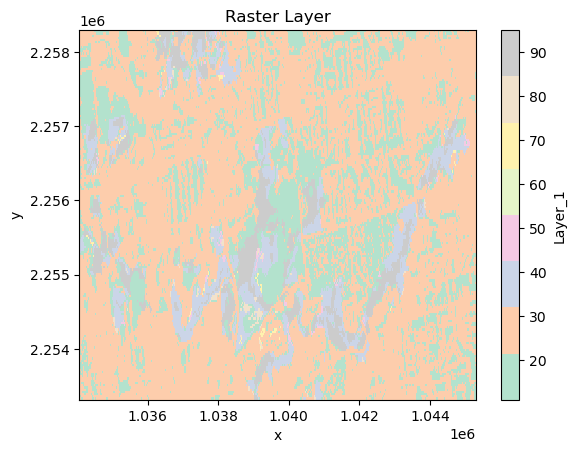

In [12]:
f, ax = plt.subplots()
ou_landcover_2021_da.plot(ax=ax, cmap='Pastel2')

ax.set(title="Raster Layer")
plt.show()


We can use the xarray `where()` method to subset the `DataArray`. For example, let's just plot the wetlands.

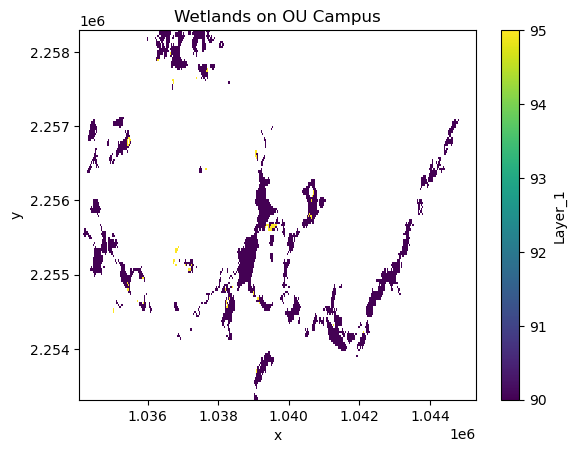

In [13]:
f, ax = plt.subplots()
ou_landcover_2021_da.where(ou_landcover_2021_da >= 90).plot(ax=ax)

ax.set(title="Wetlands on OU Campus")

plt.show()


**TODO** Could we really use a custom color maps.

## Next steps

**TODO** Give overview of overall analysis that we'll do in the module as well as what we'll do in next section.

### Question

Here's a question.

### Answer

In [1]:
print("here's the answer")

here's the answer
